# Glove Model

In [1]:
import numpy as np
import pandas as pd
import gensim
import os


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense,Embedding,GRU,LSTM
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Get the data

In [3]:
data=pd.read_csv('cleaned_hm.csv')
data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [4]:
data.shape

(100535, 9)

# Basic Data Cleaning

In [5]:
data['predicted_category'].value_counts()

predicted_category
affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: count, dtype: int64

In [6]:
data['num_sentence'].value_counts()

num_sentence
1     83711
2      9542
3      3847
4      1624
5       821
6       336
7       183
8       107
10       68
9        61
11       35
13       26
12       21
16       17
18       17
14       14
17       14
19       12
21       10
15        7
23        7
25        7
26        5
24        5
22        4
30        3
31        3
20        3
29        3
27        2
32        2
40        2
37        2
69        1
60        1
34        1
42        1
44        1
48        1
35        1
46        1
51        1
56        1
53        1
58        1
28        1
45        1
Name: count, dtype: int64

In [7]:
#deleting happy moments with less than 10 sentenses
mod_data=data.loc[data['num_sentence']<=10]
mod_data['predicted_category'].value_counts()

predicted_category
affection           34020
achievement         33966
enjoy_the_moment    11115
bonding             10700
leisure              7458
nature               1839
exercise             1202
Name: count, dtype: int64

In [8]:
#Categorical to numerical
encode={
    
    "affection":0,
    "achievement":1,
    "bonding":2,
    "enjoy_the_moment":3,
    "leisure":4,
    "nature":5,
    "exercise":6
    
    
}
encode

{'affection': 0,
 'achievement': 1,
 'bonding': 2,
 'enjoy_the_moment': 3,
 'leisure': 4,
 'nature': 5,
 'exercise': 6}

In [9]:
mod_data['predicted_category']=mod_data["predicted_category"].apply(lambda x:encode[x])
mod_data.head()

C:\Users\guruc\AppData\Local\Temp\ipykernel_8364\302242540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data['predicted_category']=mod_data["predicted_category"].apply(lambda x:encode[x])


,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,0
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,0
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,6
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,2
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,0


# Data cleaning for NLP

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guruc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [13]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

happy_lines=list()
lines=mod_data['cleaned_hm'].values.tolist()

for line in lines:
    tokens=word_tokenize(line)
    tokens=[w.lower() for w in tokens]
    
    #remove puntuations
    table=str.maketrans('','',string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    
    #remove non alphabetic characters
    words=[word for word in stripped if word.isalpha()]
    happy_lines.append(words)
    
happy_lines[:5]

[['i',
  'went',
  'on',
  'a',
  'successful',
  'date',
  'with',
  'someone',
  'i',
  'felt',
  'sympathy',
  'and',
  'connection',
  'with'],
 ['i',
  'was',
  'happy',
  'when',
  'my',
  'son',
  'got',
  'marks',
  'in',
  'his',
  'examination'],
 ['i', 'went', 'to', 'the', 'gym', 'this', 'morning', 'and', 'did', 'yoga'],
 ['we',
  'had',
  'a',
  'serious',
  'talk',
  'with',
  'some',
  'friends',
  'of',
  'ours',
  'who',
  'have',
  'been',
  'flaky',
  'lately',
  'they',
  'understood',
  'and',
  'we',
  'had',
  'a',
  'good',
  'evening',
  'hanging',
  'out'],
 ['i',
  'went',
  'with',
  'grandchildren',
  'to',
  'butterfly',
  'display',
  'at',
  'crohn',
  'conservatory']]

# Train-test split

In [14]:
validation_split=0.2
max_length=55

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(happy_lines)
sequences=tokenizer_obj.texts_to_sequences(happy_lines)

word_index=tokenizer_obj.word_index

print('Unique tokens - '+str(len(word_index)))
vocab_size=len(tokenizer_obj.word_index)+1
print('Vocab_size-'+str(vocab_size))


Unique tokens - 26138
Vocab_size-26139


In [15]:
lines_pad=pad_sequences(sequences,maxlen=max_length,padding='post')
category=mod_data['predicted_category'].values

indices=np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
category=category[indices]

n_values=np.max(category)+1
y=np.eye(n_values)[category]

num_validation_samples=int(validation_split*lines_pad.shape[0])

xtrain_pad=lines_pad[:-num_validation_samples]
ytrain=y[:-num_validation_samples]
xtest_pad=lines_pad[-num_validation_samples:]
ytest=y[-num_validation_samples:]

In [16]:
print('Shape of xtrain_pad:\t',xtrain_pad.shape)
print()
print('Shape of ytrain:\t',ytrain.shape)
print()
print('Shape of Xtest_pad:\t',xtest_pad.shape)
print('Shape of ytest:\t',ytest.shape)

Shape of xtrain_pad:	 (80240, 55)

Shape of ytrain:	 (80240, 7)

Shape of Xtest_pad:	 (20060, 55)
Shape of ytest:	 (20060, 7)


# Glove Model

In [19]:
embedding_index={}
embedding_dim=100
glove_dir="glove.twitter.27B"
f=open(os.path.join(glove_dir,'glove.twitter.27B.100d.txt'),encoding='utf-8')

for line in f:
    values=line.split()
    word=values[0]
    coeff=np.asarray(values[1:],dtype='float32')
    embedding_index[word]=coeff
    
f.close()

In [20]:
embedding_matrix=np.zeros((len(word_index)+1,embedding_dim))
for word,i in word_index.items():
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [21]:
embedding_layer=Embedding(len(word_index)+1,embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False)

In [22]:
#Build Glove model
model_glove=Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(units=32,dropout=0.2,recurrent_dropout=0.25))
model_glove.add(Dense(7,activation='softmax'))

#compile
model_glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#summary
print(model_glove.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 100)           2613900   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 2631155 (10.04 MB)
Trainable params: 17255 (67.40 KB)
Non-trainable params: 2613900 (9.97 MB)
_________________________________________________________________
None


In [25]:
checkpoint=ModelCheckpoint('model-{epoch:03d} - {val_acc:03f}.h5',
                          verbose=1,
                          monitor='val_accuracy',
                          save_best_only=True,
                          mode='auto')

In [28]:
history_glove=model_glove.fit(xtrain_pad,ytrain,batch_size=32,
                             epochs=5,
                             validation_data=(xtest_pad,ytest),
                             
                             verbose=1)

Epoch 1/5
2508/2508 [==============================] - 145s 58ms/step - loss: 1.5362 - accuracy: 0.3383 - val_loss: 1.5367 - val_accuracy: 0.3387
Epoch 2/5
2508/2508 [==============================] - 148s 59ms/step - loss: 1.5353 - accuracy: 0.3387 - val_loss: 1.5390 - val_accuracy: 0.3390
Epoch 3/5
2508/2508 [==============================] - 147s 59ms/step - loss: 1.5345 - accuracy: 0.3391 - val_loss: 1.5367 - val_accuracy: 0.3389
Epoch 4/5
2508/2508 [==============================] - 138s 55ms/step - loss: 1.5339 - accuracy: 0.3417 - val_loss: 1.5388 - val_accuracy: 0.3391
Epoch 5/5
2508/2508 [==============================] - 145s 58ms/step - loss: 1.5327 - accuracy: 0.3404 - val_loss: 1.5373 - val_accuracy: 0.3382


Text(0.5, 1.0, 'Training & Validation loss')

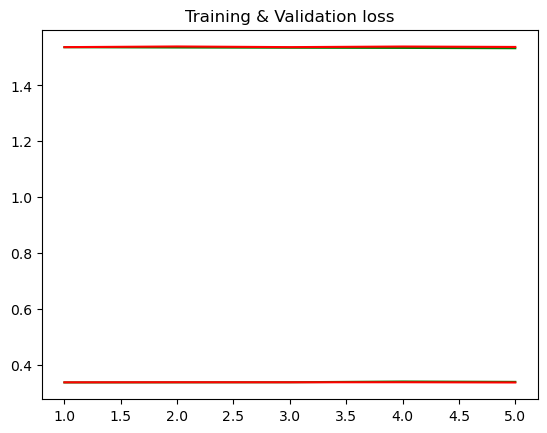

In [32]:
#plot results

import matplotlib.pyplot as plt
acc=history_glove.history['accuracy']
val_acc=history_glove.history['val_accuracy']
loss=history_glove.history['loss']
val_loss=history_glove.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title("Training & Validation Accuracy")


plt.plot(epochs,loss,'g',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title("Training & Validation loss")

Text(0.5, 1.0, 'Training & Validation Accuracy')

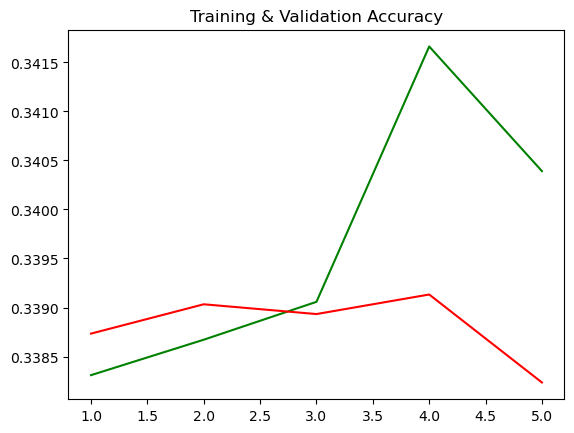

In [33]:
plt.plot(epochs,acc,'g',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title("Training & Validation Accuracy")

# Word2Vec Model